# Analyzing Census Data with Python and SQL

This project is derived from the course Databases and SQL for Data Science with Python offered by IBM on Coursera.org
https://www.coursera.org/learn/sql-data-science?specialization=ibm-data-engineer
We first store the data from website in an SQLite database. Then we will do analysis to extract insights. 

The city of Chicago released a dataset of socioeconomic data to the Chicago City Portal https://tinyurl.com/5xn6f5uj
This dataset contains a selection of six socioeconomic indicators of public health significance and a “hardship index,” by Chicago community area, for the years 2008 – 2012. This dataset contains 78 rows and 9 columns. 

The indicators are 

1. Community Area Number (ca): Used to uniquely identify each row of the dataset
2. Community Area Name (community_area_name): The name of the region in the city of Chicago
3. Percent of Housing Crowded (percent_of_housing_crowded): the percent of occupied housing units with more than one person per room
4. Percent Households Below Poverty (percent_households_below_poverty): the percent of households living below the federal poverty level
5. Percent Aged 16+ Unemployed (percent_aged_16_unemployed): the percent of persons in the labor force over the age of 16 years that are unemployed
6. Percent Aged 25+ without High School Diploma (percent_aged_25_without_high_school_diploma): the percent of persons over the age of 25 years without a high school diploma
7. Percent Aged Under 18 or Over 64: the percent of population under 18 or over 64 years of age (percent_aged_under_18_or_over_64): (ie. dependency)
8. Per Capita Income (per_capita_income_): Community Area per capita income is estimated as the sum of tract-level aggragate incomes divided by the total population
9. Hardship Index (hardship_index): Score that incorporates each of the six selected socioeconomic indicators

## Import necessary libraries

In [1]:
import csv, sqlite3
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Connect to the database

In [2]:
# First install the ipython-sql extention.
!pip3 install ipython-sql

In [3]:
# Load the SQL module
%load_ext sql

In [4]:
# Create database connection
con = sqlite3.connect("socioeconomic.db")
# Create Cursor object using the cursor() method of the con class.
cur = con.cursor()

In [5]:
# Establish connection
%sql sqlite:///socioeconomic.db

## Store the dataset in a table

In [6]:
# Read the csv files from the given url into a pandas dataframe
df = pandas.read_csv('https://data.cityofchicago.org/resource/jcxq-k9xf.csv')
df.to_sql("chicago_socioeconomic_data", con, if_exists='replace', index=False, method="multi")

78

In [7]:
# Verify that the table creation was successful by making a basic query
%sql SELECT * FROM chicago_socioeconomic_data limit 5;

 * sqlite:///socioeconomic.db
Done.


ca,community_area_name,percent_of_housing_crowded,percent_households_below_poverty,percent_aged_16_unemployed,percent_aged_25_without_high_school_diploma,percent_aged_under_18_or_over_64,per_capita_income_,hardship_index
1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


## Data Analysis by SQL queries

In [8]:
# How many community areas in Chicago have a hardship index greater than 50.0?
%sql SELECT COUNT(*) as cnt FROM chicago_socioeconomic_data WHERE hardship_index > 50.0;

 * sqlite:///socioeconomic.db
Done.


cnt
38


In [9]:
# What is the maximum value of hardship index in this dataset?
%sql SELECT MAX(hardship_index) as max_hardship FROM chicago_socioeconomic_data;

 * sqlite:///socioeconomic.db
Done.


max_hardship
98.0


In [10]:
# Which community area which has the highest hardship index?
%sql select community_area_name from chicago_socioeconomic_data where hardship_index = (select max(hardship_index) from chicago_socioeconomic_data)

 * sqlite:///socioeconomic.db
Done.


community_area_name
Riverdale


In [11]:
# Which Chicago community areas have per-capita incomes greater than $60,000?
%sql SELECT community_area_name FROM chicago_socioeconomic_data WHERE per_capita_income_ > 60000;

 * sqlite:///socioeconomic.db
Done.


community_area_name
Lake View
Lincoln Park
Near North Side
Loop


 * sqlite:///socioeconomic.db
Done.


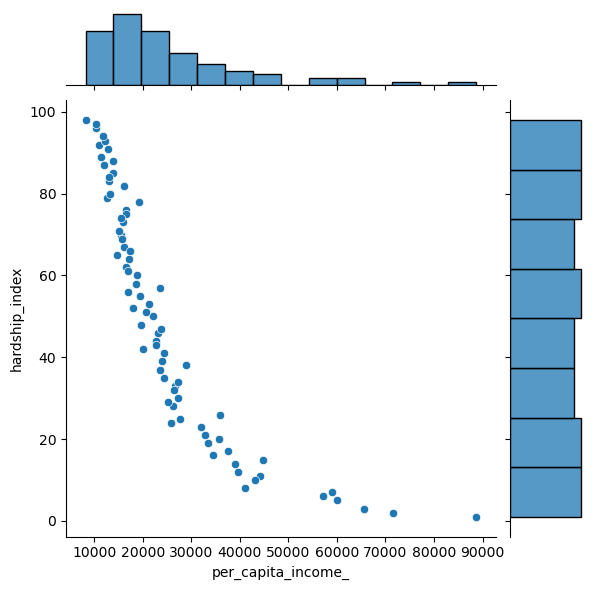

In [12]:
# Create a scatter plot using the variables per_capita_income_ and hardship_index. 
# Explain the correlation between the two variables.
# Per Capita Income rises as the Hardship Index decreases. We can see that the points on the scatter plot are somewhat 
# closer to a straight line in the negative direction, so there is a negative correlation between the two variables. 
income_vs_hardship = %sql SELECT per_capita_income_, hardship_index FROM chicago_socioeconomic_data;
plot1 = sns.jointplot(x='per_capita_income_',y='hardship_index', data=income_vs_hardship.DataFrame())

 * sqlite:///socioeconomic.db
Done.


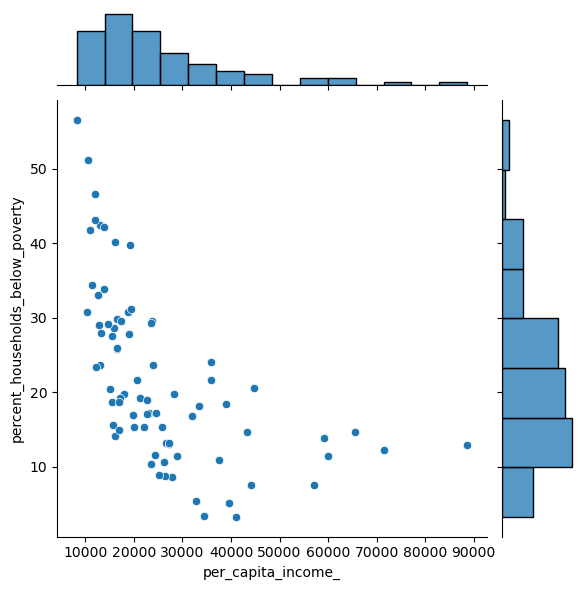

In [13]:
# We explore the correlation between per_capita_income_ and percent_households_below_poverty.
# The situation is similar to the previous one. As income increases, below poverty percentage decreases. 
# Generally the two variables have a negative correlation.
income_vs_poverty = %sql SELECT per_capita_income_, percent_households_below_poverty FROM chicago_socioeconomic_data;
plot2 = sns.jointplot(x='per_capita_income_',y='percent_households_below_poverty', data=income_vs_poverty.DataFrame())

 * sqlite:///socioeconomic.db
Done.


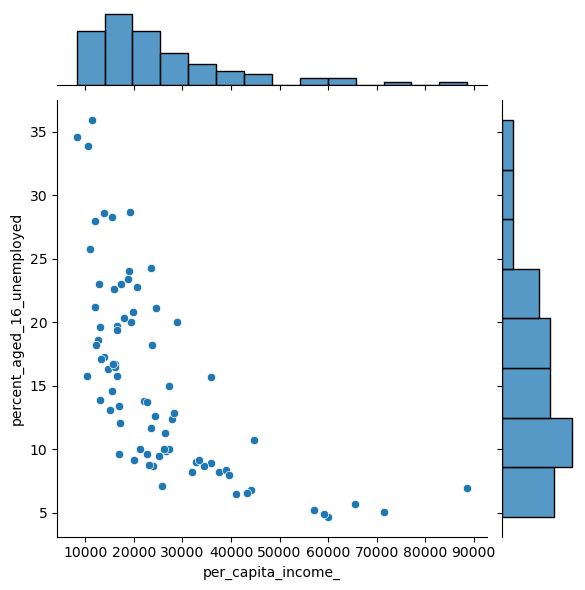

In [14]:
income_vs_unemployed = %sql SELECT per_capita_income_, percent_aged_16_unemployed FROM chicago_socioeconomic_data;
plot3 = sns.jointplot(x='per_capita_income_',y='percent_aged_16_unemployed', data=income_vs_unemployed.DataFrame())

 * sqlite:///socioeconomic.db
Done.


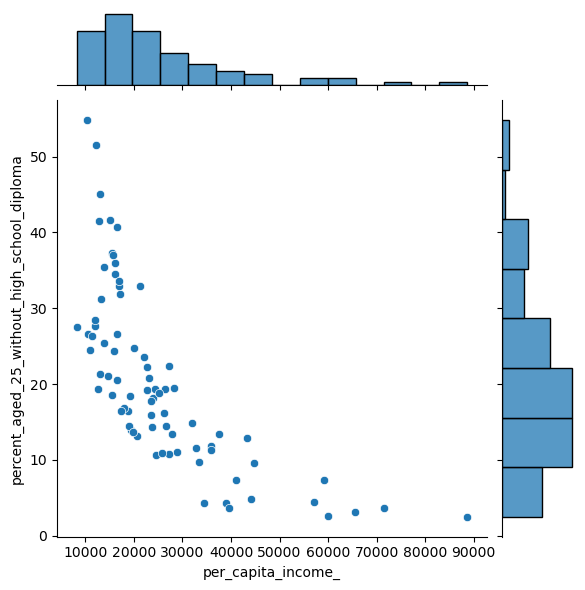

In [15]:
income_vs_nodiploma = %sql SELECT per_capita_income_, percent_aged_25_without_high_school_diploma FROM chicago_socioeconomic_data;
plot4 = sns.jointplot(x='per_capita_income_',y='percent_aged_25_without_high_school_diploma', data=income_vs_nodiploma.DataFrame())

 * sqlite:///socioeconomic.db
Done.


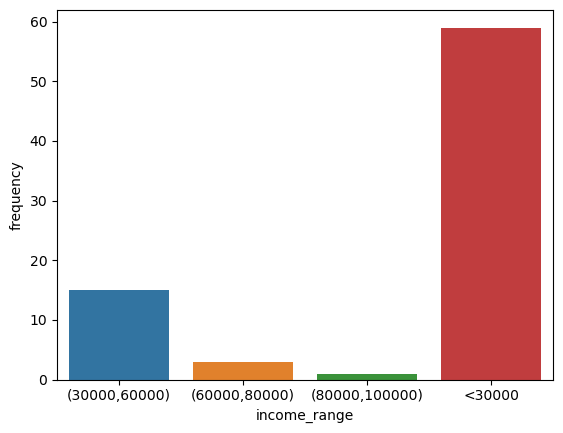

In [16]:
# Most of the capita_income lie below 30000. Second likely possible range is between 30000 and 60000. 
# Very few within 80000-100000. None above 100000.
capita_income_distribution = %sql \
with range_info as ( \
    SELECT per_capita_income_, \
        case when per_capita_income_ > 100000 then ">100000" \
             when per_capita_income_ < 100000 and per_capita_income_ > 80000 then "(80000,100000)" \
             when per_capita_income_ < 80000 and per_capita_income_ > 60000 then "(60000,80000)" \
             when per_capita_income_ < 60000 and per_capita_income_ > 30000 then "(30000,60000)" \
             when per_capita_income_ < 30000 then "<30000" end as income_range \
    from chicago_socioeconomic_data \
                   ) \
select income_range, count(income_range) as frequency \
from range_info \
group by 1; 
plot5 = sns.barplot(x='income_range',y='frequency', data=capita_income_distribution.DataFrame())

In [17]:
# Free all resources by closing both the cursor and the connection.
cur.close()
con.close()